In [1]:

import multiprocessing
print(multiprocessing.cpu_count())

import psutil
print(f"Available memory before training: {psutil.virtual_memory().available / 1e9:.2f} GB")

12
Available memory before training: 3.03 GB


In [2]:

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
pd.set_option('display.max_info_columns', 200) #caps at 200, use None to show all
pd.set_option('display.max_rows', 200)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import joblib
import pickle

In [3]:

token = 'p26'
X_with_proba = pd.read_pickle('p24_X_with_proba.pkl')
    
print(X_with_proba.shape) 

(78743, 176)


In [4]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, log_loss, roc_auc_score
import xgboost

In [5]:

X = X_with_proba.drop(columns=['readmitted'], axis=1)
y_prep = X_with_proba['readmitted']

le = LabelEncoder()
y = le.fit_transform(y_prep)  # where y_3class = study['readmitted']

# Save this for later
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

del X_with_proba, y_prep

{'<30': 0, '>30': 1, 'NO': 2}


In [6]:

# Define features to INCLUDE for training
exclude_features = ['patient_nbr', 'encounter_id', 'diagnosis_tuple', 'dummy'] 
numeric_features = [col for col in X.columns if col not in exclude_features and is_numeric_dtype(X[col])]
object_features =  [col for col in X.columns if col not in exclude_features and X[col].dtype == 'object']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), object_features)
    ])

In [7]:

%%time
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': np.logspace(-3, 0, 10),
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_lambda': np.logspace(-3, 3, 10),
    'reg_alpha': np.logspace(-3, 3, 10)
}

xgb_clf = xgboost.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=26
)

random_search_xgb_3way = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=75,
    scoring='f1_macro',  # or 'accuracy', 'neg_log_loss'
    cv=5,
    verbose=1,
    random_state=26,
    n_jobs=-1
)

xgb_tune_3way = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', random_search_xgb_3way )  
])

xgb_tune_3way.fit(X_train, y_train)

filename=f"{token}_xgb_tune_3way.pkl"
with open(filename, "wb") as file:
    pickle.dump(xgb_tune_3way, file)
print(f"Model saved as {filename}")

best_params = xgb_tune_3way['model'].best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Model saved as p26_xgb_tune_3way.pkl
Best Parameters: {'subsample': 0.625, 'reg_lambda': 0.001, 'reg_alpha': 10.0, 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.046415888336127774, 'gamma': 0.125, 'colsample_bytree': 0.875}
CPU times: total: 1min 21s
Wall time: 30min 12s


In [8]:

 # Extract cv_results_ safely
cv_results_df = pd.DataFrame(xgb_tune_3way['model'].cv_results_)

# Identify failed fits (mean_test_score is NaN)
failed_fits = cv_results_df[cv_results_df['mean_test_score'].isna()]
print("❌ Failed Fits:")
print(failed_fits[['params']])
print(f"Total failed fits: {len(failed_fits)}")

# Create leaderboard from successful fits
successful_fits = cv_results_df[cv_results_df['mean_test_score'].notna()]

leaderboard = successful_fits[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
].sort_values(by='rank_test_score').reset_index(drop=True)

# Export leaderboard
leaderboard.to_csv(f'{token}_xgb_tune_3way_leaderboard.csv', index=False)

# Show top 10
print("🏆 Top 10 Hyperparameter Sets:")
print(leaderboard.head(10))


❌ Failed Fits:
Empty DataFrame
Columns: [params]
Index: []
Total failed fits: 0
🏆 Top 10 Hyperparameter Sets:
                                              params  mean_test_score  \
0  {'subsample': 0.625, 'reg_lambda': 0.001, 'reg...         0.881318   
1  {'subsample': 0.625, 'reg_lambda': 2.154434690...         0.881096   
2  {'subsample': 0.5, 'reg_lambda': 46.4158883361...         0.879853   
3  {'subsample': 0.625, 'reg_lambda': 0.004641588...         0.879684   
4  {'subsample': 1.0, 'reg_lambda': 10.0, 'reg_al...         0.879466   
5  {'subsample': 0.625, 'reg_lambda': 2.154434690...         0.879323   
6  {'subsample': 1.0, 'reg_lambda': 46.4158883361...         0.878703   
7  {'subsample': 0.875, 'reg_lambda': 0.001, 'reg...         0.878703   
8  {'subsample': 0.5, 'reg_lambda': 215.443469003...         0.878328   
9  {'subsample': 1.0, 'reg_lambda': 215.443469003...         0.878069   

   std_test_score  rank_test_score  
0        0.002736                1  
1        0.0

In [9]:

%%time
xgb_3way = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model',xgboost.XGBClassifier(objective='multi:softprob'
                                   , **best_params
                                   , num_class=3
                                   , eval_metric='mlogloss'
                                   , random_state=27
                                   , n_jobs=-1))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

xgb_3way.fit(X_train, y_train)

filename=f"{token}_xgb_3way.pkl"
with open(filename, "wb") as file:
    pickle.dump(xgb_3way, file)
print(f"Model saved as {filename}")


Model saved as p26_xgb_3way.pkl
CPU times: total: 1min 6s
Wall time: 11.7 s


C:\Users\lelan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\lelan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [14] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 0.9264080259064068


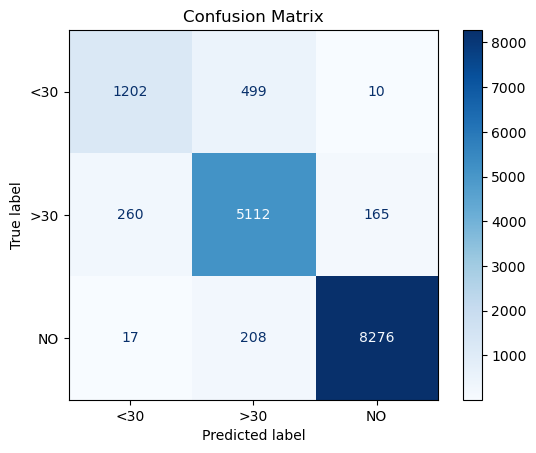

Classification Report:
              precision    recall  f1-score   support

         <30       0.81      0.70      0.75      1711
         >30       0.88      0.92      0.90      5537
          NO       0.98      0.97      0.98      8501

    accuracy                           0.93     15749
   macro avg       0.89      0.87      0.88     15749
weighted avg       0.93      0.93      0.93     15749

F1 Macro: 0.8767753309469216
F1 Weighted: 0.9254481923984961
Log Loss: 0.14979819390652843
Multiclass ROC AUC (macro average): 0.9889574532440024


In [10]:

# Predict class labels
y_pred = xgb_3way.predict(X_test)

# Predict class probabilities
y_proba = xgb_3way.predict_proba(X_test)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 4. F1 Scores
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print("F1 Macro:", f1_macro)
print("F1 Weighted:", f1_weighted)

# 5. Log Loss
logloss = log_loss(y_test, y_proba)
print("Log Loss:", logloss)

# 6. Multiclass ROC AUC (optional)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print("Multiclass ROC AUC (macro average):", roc_auc)


In [11]:

# Step 1: Get the trained XGBoost model from your pipeline
model = xgb_3way.named_steps['model'].best_estimator_ if hasattr(xgb_3way.named_steps['model'], 'best_estimator_') else xgb_3way.named_steps['model']

# Step 2: Get the preprocessor
preprocessor = xgb_3way.named_steps['preprocessor']

# Step 3: Get feature names from numeric and categorical transformers
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][2]

# Get encoded feature names from OneHotEncoder
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine all feature names
feature_names = numeric_features + list(cat_feature_names)

# Step 4: Get feature importances
importances = model.feature_importances_

# Step 5: Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 6: Save to CSV for Excel
importance_df.to_csv(f"{token}_xgb_3way_feature_importance.csv", index=False)

# Optional: Preview the top features
print(importance_df.head(10))


                                               Feature  Importance
155                                      predict_proba    0.282123
143                              mb_readmitted_gt30_ct    0.198599
142                              mb_readmitted_lt30_ct    0.178969
144                                mb_readmitted_no_ct    0.169856
140                                       encounter_ct    0.041005
14                                 distinct_diag_count    0.011073
6                                     number_inpatient    0.010851
150                             mb_number_inpatient_ct    0.006809
151                             mb_number_diagnoses_ct    0.004946
202  discharge_disposition_Discharged/transferred t...    0.002741
